In [1]:
import datetime
import matplotlib.pyplot as plt
import sys
import os
import dlib
import glob
import cv2  #opencv 사용
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from PIL import Image
import os
from sklearn.utils import shuffle
import cv2
import glob
import imageio
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt
from IPython import display
from mtcnn import MTCNN


Using TensorFlow backend.


In [2]:
def land_crop(img):
    l= land_mark(img)
    start_h = 0
    start_w = 0
    end_w = 0
    end_h = 0
    h_check=False
    w_check=False
    for i in range(64):
        for j in range(64):
            if h_check == False and np.mean(l[i,j,:])!=0:
                start_h = i
                h_check = True
                break
        if h_check==True:
            h_check = False
            break
                                        
    for i in range(64):
        for j in range(64):
            if h_check == False and np.mean(l[63-i,j,:])!=0:
                end_h = 63-i
                h_check = True
                break
        if h_check==True:
            h_check = False
            break                                        
                   
    for i in range(64):
        for j in range(64):
            if w_check == False and np.mean(l[j,i,:])!=0:
                start_w = i
                w_check = True
                break
        if w_check==True:
            w_check = False
            break    
                                        
    for i in range(64):
        for j in range(64):
            if w_check == False and np.mean(l[j,63-i,:])!=0:
                end_w = 63-i
                w_check = True
                break
        if w_check==True:
            w_check = False
            break                     
    plt.imshow(l[start_h:end_h , start_w :end_w,:])   
   # img[start_h:end_h , start_w :end_w,:]
    return start_h, end_h , start_w , end_w

In [3]:
def land_mark(img):
    predictor_path = "shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    cvImg = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_AREA)
    dets = detector(img, 1)
    cvImg-= cvImg
    if len(dets)<1 :
        print("검출x")
        
        # 파일에서 이미지 불러오기
    for k, d in enumerate(dets):
            # k 얼굴 인덱스
            # d 얼굴 좌표
        
            # 인식된 좌표에서 랜드마크 추출 
        shape = predictor(img, d)
            # num_parts(랜드마크 구조체)를 하나씩 루프를 돌린다.
        
        for i in range(0, shape.num_parts):
                # 해당 X,Y 좌표를 두배로 키워 좌표를 얻고
            x2 = shape.part(i).x*2
            y2 = shape.part(i).y*2
                #print(x,y)
            cv2.circle(cvImg, (x2, y2), 2, (0, 0, 255), -1)
                # 좌표값 출력
    cvImg = cv2.resize(cvImg, (64,64))
    return cvImg


In [4]:
def encoder():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same' , input_shape=[64, 64, 3]))
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (1, 1), activation='relu', padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(200))
    return model

def decoder():
    model = tf.keras.Sequential()
    dropout = 0.4 
    depth = 64 *4
    dim = 8
    model.add(layers.Dense(dim*dim*depth, input_dim=200))
    model.add(layers.BatchNormalization(momentum=0.9)) 
    model.add(layers.Activation('relu'))
    model.add(layers.Reshape((dim, dim, depth))) 
    model.add(layers.Dropout(dropout)) 
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(int(depth/4), 5, padding='same')) 
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Activation('relu')) 
    model.add(layers.Conv2DTranspose(int(depth/8), 5, padding='same')) 
    model.add(layers.BatchNormalization(momentum=0.9)) 
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(3, 5, padding='same'))
    model.add(layers.Activation('tanh'))
    return model              

def autoencoder(encoder , decoder):
    model = tf.keras.Sequential()
    model = tf.keras.models.clone_model(encoder)
    model.add(decoder)
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def build_adversarial_model(gen_model, dis_model):
    model = tf.keras.Sequential()
    model.add(gen_model)
    dis_model.trainable = False
    model.add(dis_model)
    return model

In [5]:
encode = encoder()
decode_iu = decoder()
#decode_kim = decoder()|
#generator_kim = autoencoder(encode,decode_kim)
generator_iu = autoencoder(encode,decode_iu)

#generator_kim.load_weights("generator_besiut_kim.h5")
#generator_iu.load_weights("generator_best_output (16).h5")
generator_iu.load_weights("generator_best_output (11).h5")


In [6]:
def restore_image(img):
    
    #img 원본이미지
    conv_img = img.copy()
    for i in range(64):      ##RGB 피부색만 남기기
        for j in range(64):
            if conv_img[i,j,2]<110:
                conv_img[i,j,:]=0
    
    for i in range(64):            ##비어있는 부분 복원
        start=0 
        end = 0 
        check =False
        for j in range(64):
            if check == False and np.mean(conv_img[j,i,:]) != 0:
                start=j
                check = True
            elif check == True and np.mean(conv_img[j,i,:]) != 0:
                end = j
            
        for k in range(start+1, end):
            conv_img[k,i,:] = img[k,i,:] 
            
        
    return conv_img

In [7]:
capture = cv2.VideoCapture("lee2.mp4")
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))  ##결과 영상 출력
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('test999.avi', fourcc,30.0, (int(width*0.8), int(height*0.4)))

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# 랜드마크 파일 경로
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
print(capture.get(cv2.CAP_PROP_FRAME_COUNT))


# 이미지 경로
index=0
while True:
    ret, img = capture.read()
    #cv2.imshow("image", img)
    if capture.get(cv2.CAP_PROP_POS_FRAMES) == capture.get(cv2.CAP_PROP_FRAME_COUNT):
        writer.release()
        cv2.destroyAllWindows()
        capture.release()    
        
    
    #print(capture.get(cv2.CAP_PROP_POS_FRAMES),capture.get(cv2.CAP_PROP_FRAME_COUNT))

    if not ret :
        exit()
    img = cv2.resize(img, (int(width*0.6), int(height*0.6))) 

    faces = face_cascade.detectMultiScale(img, 1.3,5)
    try:
        for (x,y,w,h) in faces:
            roi= img[y:y+h, x:x+w]  
        roi = cv2.resize(roi, (64,64))  
        #cvImg = random_warp(img)[0]
        cvImg = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_AREA)
        dets = detector(roi, 1)
    except: 
        continue
        
    if len(dets)<1 :
        print("검출 x")
        continue
        
    cvImg -= cvImg
    # 파일에서 이미지 불러오기
    for k, d in enumerate(dets):
        # k 얼굴 인덱스
        # d 얼굴 좌표
        
        # 인식된 좌표에서 랜드마크 추출 
        shape = predictor(roi, d)
        # num_parts(랜드마크 구조체)를 하나씩 루프를 돌린다.
        
        for i in range(0, shape.num_parts):
            # 해당 X,Y 좌표를 두배로 키워 좌표를 얻고
            x2 = shape.part(i).x*2
            y2 = shape.part(i).y*2
            #print(x,y)
            cv2.circle(cvImg, (x2, y2), 2, (0, 0, 255), -1)
            # 좌표값 출력
    cvImg = cv2.resize(cvImg, (64,64))  
    b, g, r = cv2.split(cvImg)
    cvImg = cv2.merge([r,g,b])
    cvImg = np.array([cvImg])/255
    conv_img = generator_iu.predict(cvImg)
    conv_img = cv2.resize(conv_img[0], (64,64))
    cvImg = cvImg[0]
    #plt.imshow(conv_img)
    cv2.imwrite("q.png",conv_img*255)
    conv_img = cv2.imread("q.png")
    '''b, g, r = cv2.split(conv_img)
    conv_img = cv2.merge([r,g,b])

        total = cv2.hconcat([roi,conv_img])
    total = cv2.resize(total, (512, 256))
    
    cv2.imshow("image", total)
    writer.write(total)
        '''
    
    b, g, r = cv2.split(roi)
    roi = cv2.merge([r,g,b])
    
    
    
    
    start_h=0
    start_w=0
    end_h=63
    end_w=63
    check = False 
    
    '''    for i in range(64):
        for j in range(64):
            if check == False and np.mean(cvImg[i,j,:]) !=0:
                start_h = i
                check = True
                break
        if check == True :
            check = False 
            break

    for i in range(64):
        for j in range(64):
            if check == False and np.mean(cvImg[63 - i,j,:]) !=0:
                end_h = 63 -i
                check = True
                break
        if check == True :
            check = False 
            break        
    for i in range(64):
        for j in range(64):
            if  check == False and np.mean(cvImg[j,i,:]) !=0:
                start_w = i
                check = True
                break
        if check == True :
            check = False 
            break     

    for i in range(64):
        for j in range(64):
            if check == False and np.mean(cvImg[j,63 -i,:]) !=0:
                end_w = 63 -i
                check = True
                break       
        if check == True :
            check = False 
            break'''
    
    
    
    
    real = restore_image(conv_img)


    first_pos= 0
    second_pos = 0
    first_check=False
    for i in range(0,30):
        for j in range(34):
            if first_check == False and np.mean(real[i, 63 - j , :]) != 0:
                first_pos = 63-j
                first_check = True
                continue
            elif first_check == True and np.mean(real[i, 63 - j , :]) == 0:
                second_pos = 63 - j
        for k in range(second_pos, 64):
            real[i, k , :] = 0
    real2 =real.copy()        
    for i in range(64):      ##RGB 피부색만 남기기
        for j in range(64):
            if real[i,j,2] == 0:
                real[i,j,:]= roi[i,j,:]


    median_index = []
    for i in range(64):
        for j in range(64):
            if np.mean(real2[i, 63 - j , :]) != 0:
                median_index.append([i, 63 - j])
                break
    for i in median_index:        
        for j in range(8):
            if i[1] < 60 and i[0] < 15:
                real[i[0], i[1]-j+2, :] = roi[i[0], i[1]-j+2, :]

        if i[1] < 60 and i[0] < 15:
            for j in range(10):        
                ave_R = real[i[0], i[1]-4+j : i[1]+2+j, 0 ].mean()
                ave_G = real[i[0], i[1]-4+j : i[1]+2+j, 1 ].mean()
                ave_B = real[i[0], i[1]-4+j : i[1]+2+j, 2 ].mean()
                real[i[0], i[1]-4+j, 0] = ave_R
                real[i[0], i[1]-4+j, 1] = ave_G
                real[i[0], i[1]-4+j, 2] = ave_B



    b, g, r = cv2.split(real)
    real = cv2.merge([r,g,b])
    b, g, r = cv2.split(conv_img)
    conv_img = cv2.merge([r,g,b])
    #conv_img = cv2.resize(conv_img, (w,h))   
    real = cv2.resize(real, (w,h))   
    

    
    img_ori=img.copy()
    img[y:y+h, x:x+w] = real   
    #img_ori[y:y+h, x:x+w] = conv_img   

    total = cv2.hconcat([img_ori,img])
    #total = cv2.hconcat([conv_img,real])
    total = cv2.resize(total, (int(width*0.8), int(height*0.4)))
    cv2.imshow("image", total)
    #writer.write(total)
    key = cv2.waitKey(1)
    index+=1
    if key == 27:
        #writer.release()
        cv2.destroyAllWindows()
        capture.release()
        break


593.0


(-0.5, 63.5, 63.5, -0.5)

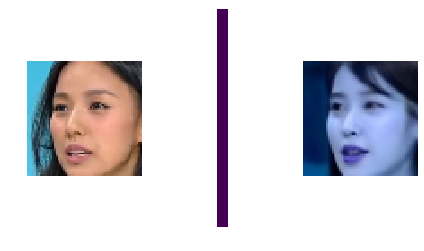

In [8]:
plt.figure(figsize=(7,4))
plt.subplot(1,3,1)
plt.imshow(roi)
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(cvImg[0])
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(conv_img)
plt.axis("off")

In [10]:
test =cvImg[0]

In [43]:
start_h=0
start_w=0
end_h=63
end_w=63
check = False 
for i in range(64):
    for j in range(64):
        if check == False and np.mean(test[i,j,:]) !=0:
            start_h = i
            check = True
            break
    if check == True :
        check = False 
        break

for i in range(64):
    for j in range(64):
        if check == False and np.mean(test[63 - i,j,:]) !=0:
            end_h = 63 -i
            check = True
            break
    if check == True :
        check = False 
        break        
for i in range(64):
    for j in range(64):
        if  check == False and np.mean(test[j,i,:]) !=0:
            start_w = i
            check = True
            break
    if check == True :
        check = False 
        break     

for i in range(64):
    for j in range(64):
        if check == False and np.mean(test[j,63 -i,:]) !=0:
            end_w = 63 -i
            check = True
            break       
    if check == True :
        check = False 
        break

In [44]:
start_h,end_h, start_w,end_w

(13, 63, 12, 63)

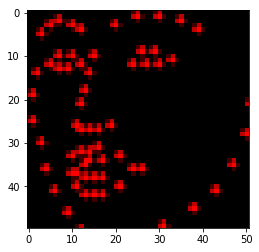

In [45]:
plt.imshow(test[start_h : end_h , start_w : end_w , :])


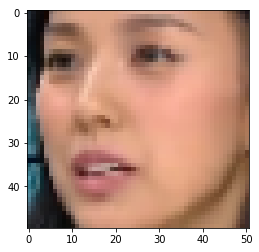

In [46]:
plt.imshow(roi[start_h : end_h , start_w : end_w , :])


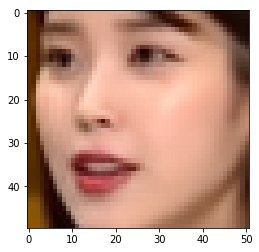

In [52]:
plt.imshow(conv_img[start_h : end_h , start_w : end_w , :])


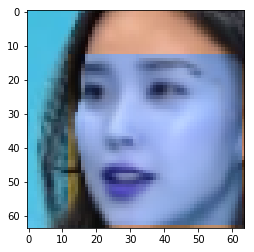

In [58]:
plt.imshow(roi)


In [61]:
roi[start_h : end_h , start_w : end_w , :] =real[start_h : end_h , start_w : end_w , :]

In [59]:
real = cv2.resize(real, (64,64))  
b, g, r = cv2.split(real)
real = cv2.merge([r,g,b])

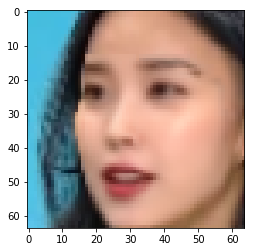

In [62]:
plt.imshow(roi)

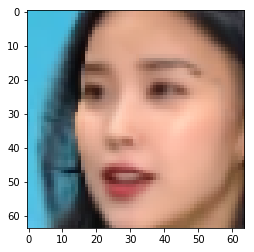

In [63]:
plt.imshow(real)

In [74]:
test = cv2.imread("test.png")


In [79]:
test = restore_image(test)

In [573]:
first_pos= 0
second_pos = 0
first_check=False
for i in range(0,30):
    for j in range(34):
        if first_check == False and np.mean(test[i, 63 - j , :]) != 0:
            first_pos = 63-j
            first_check = True
            continue
        elif first_check == True and np.mean(test[i, 63 - j , :]) == 0:
            second_pos = 63 - j
    for k in range(second_pos, 64):
        test[i, k , :] = 0

In [473]:
start_check = False
for i in range(64):      ##RGB 피부색만 남기기
    for j in range(64):
        if test[i,j,2] == 0:
            test[i,j,:]= roi[i,j,:]

(-0.5, 59.5, 59.5, -0.5)

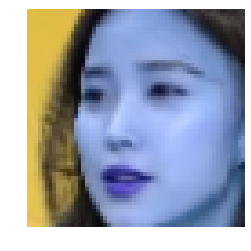

In [23]:
plt.imshow(img[y:y+h, x:x+w])
plt.axis("off")


In [15]:
b, g, r = cv2.split(total)
total = cv2.merge([r,g,b])

(-0.5, 767.5, 215.5, -0.5)

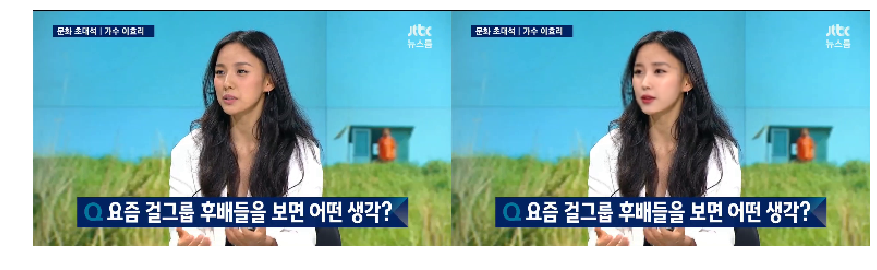

In [16]:
plt.figure(figsize=(15,10))
plt.imshow(total)
plt.axis("off")


In [39]:
b, g, r = cv2.split(total)
total = cv2.merge([r,g,b])

In [518]:
for i in median_index:
    if i[1] < 60 and i[0] < 17:
        real2[i[0], i[1], :] = roi[i[0], i[1], :]
        real2[i[0], i[1]-1, :] = roi[i[0], i[1]-1, :]
        real2[i[0], i[1]-2, :] = roi[i[0], i[1]-2, :]
        real2[i[0], i[1]-3, :] = roi[i[0], i[1]-3, :]
        real2[i[0], i[1]+1, :] = roi[i[0], i[1]+1, :]


In [ ]:
capture = cv2.VideoCapture(0)
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))  ##결과 영상 출력
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('test6.avi', fourcc, 30.0, (int(width*0.6), int(height*0.3)))

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# 랜드마크 파일 경로
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# 이미지 경로
index=0
while True:
    ret, img = capture.read()
    img = cv2.resize(img, (int(img.shape[1]*0.3),int(img.shape[0]*0.3))) 
    faces = face_cascade.detectMultiScale(img, 1.3,5)
    try:
        for (x,y,w,h) in faces:
            roi= img[y:y+h, x:x+w]        
        roi = cv2.resize(roi, (64,64))  
        #cvImg = random_warp(img)[0]
        cvImg = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_AREA)
        dets = detector(roi, 1)
    except: continue
    if len(dets)<1 :
        print("검출 x")
        continue
        
    cvImg -= cvImg
    # 파일에서 이미지 불러오기
    for k, d in enumerate(dets):
        # k 얼굴 인덱스
        # d 얼굴 좌표
        
        # 인식된 좌표에서 랜드마크 추출 
        shape = predictor(roi, d)
        # num_parts(랜드마크 구조체)를 하나씩 루프를 돌린다.
        
        for i in range(0, shape.num_parts):
            # 해당 X,Y 좌표를 두배로 키워 좌표를 얻고
            x2 = shape.part(i).x*2
            y2 = shape.part(i).y*2
            #print(x,y)
            cv2.circle(cvImg, (x2, y2), 2, (0, 0, 255), -1)
            # 좌표값 출력
    cvImg = cv2.resize(cvImg, (64,64))  
    b, g, r = cv2.split(cvImg)
    cvImg = cv2.merge([r,g,b])
    cvImg = np.array([cvImg])/255
    conv_img = generator_iu.predict(cvImg)
    conv_img = cv2.resize(conv_img[0], (64,64))
    cvImg = cvImg[0]
    #plt.imshow(conv_img)
    cv2.imwrite("q.png",conv_img*255)
    conv_img = cv2.imread("q.png")
    '''b, g, r = cv2.split(roi)
    roi = cv2.merge([r,g,b])
    start_h=0
    start_w=0
    end_h=63
    end_w=63
    check = False 
    
    for i in range(64):
        for j in range(64):
            if check == False and np.mean(cvImg[i,j,:]) !=0:
                start_h = i
                check = True
                break
        if check == True :
            check = False 
            break

    for i in range(64):
        for j in range(64):
            if check == False and np.mean(cvImg[63 - i,j,:]) !=0:
                end_h = 63 -i
                check = True
                break
        if check == True :
            check = False 
            break        
    for i in range(64):
        for j in range(64):
            if  check == False and np.mean(cvImg[j,i,:]) !=0:
                start_w = i
                check = True
                break
        if check == True :
            check = False 
            break     

    for i in range(64):
        for j in range(64):
            if check == False and np.mean(cvImg[j,63 -i,:]) !=0:
                end_w = 63 -i
                check = True
                break       
        if check == True :
            check = False 
            break
            
    real = restore_image(conv_img)

    
    first_pos= 0
    second_pos = 0
    first_check=False
    for i in range(0,30):
        for j in range(34):
            if first_check == False and np.mean(real[i, 63 - j , :]) != 0:
                first_pos = 63-j
                first_check = True
                continue
            elif first_check == True and np.mean(real[i, 63 - j , :]) == 0:
                second_pos = 63 - j
        for k in range(second_pos, 64):
            real[i, k , :] = 0
    real2 =real.copy()        
    for i in range(64):      ##RGB 피부색만 남기기
        for j in range(64):
            if real[i,j,2] == 0:
                real[i,j,:]= roi[i,j,:]


    median_index = []
    for i in range(64):
        for j in range(64):
            if np.mean(real2[i, 63 - j , :]) != 0:
                median_index.append([i, 63 - j])
                break
    for i in median_index:        
        for j in range(8):
            if i[1] < 60 and i[0] < 15:
                real[i[0], i[1]-j+2, :] = roi[i[0], i[1]-j+2, :]

        if i[1] < 60 and i[0] < 15:
            for j in range(10):        
                ave_R = real[i[0], i[1]-4+j : i[1]+2+j, 0 ].mean()
                ave_G = real[i[0], i[1]-4+j : i[1]+2+j, 1 ].mean()
                ave_B = real[i[0], i[1]-4+j : i[1]+2+j, 2 ].mean()
                real[i[0], i[1]-4+j, 0] = ave_R
                real[i[0], i[1]-4+j, 1] = ave_G
                real[i[0], i[1]-4+j, 2] = ave_B



    b, g, r = cv2.split(real)
    real = cv2.merge([r,g,b])
    b, g, r = cv2.split(conv_img)
    conv_img = cv2.merge([r,g,b])
    #roi[start_h : end_h , start_w : end_w , :] =real[start_h : end_h , start_w : end_w , :]
    real = cv2.resize(real, (w,h))   
    
    img_ori=img.copy()
    img[y:y+h, x:x+w] = real   '''
    b, g, r = cv2.split(conv_img)
    conv_img = cv2.merge([r,g,b])
    real = cv2.resize(conv_img, (w,h))
    img_ori=img.copy()
    img[y:y+h, x:x+w] = real
    cv2.imshow("image", img)
    writer.write(total)
    key = cv2.waitKey(33)
    index+=1
    if key == 27:
        writer.release()
        cv2.destroyAllWindows()
        capture.release()
        capture2.release()
        break


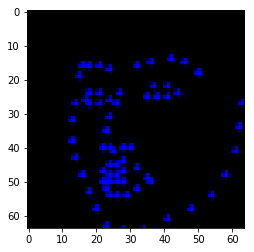

In [70]:
plt.imshow(cvImg)

In [14]:
result = []
for i in range(64):
    for i in range(64):
        if np.mean(cvImg[i, j, :])==0:
            result = cvImg[:i, :j, :]

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

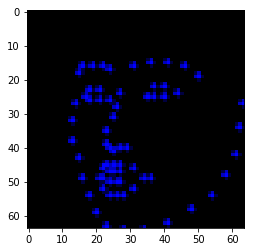

In [69]:
plt.imshow(cvImg2)